# Generating Fake Images with Convolutional GAN (DCGAN)

This notebook implements a Deep Convolutional GAN (DCGAN) to generate fake MNIST digits. The architecture uses convolutional and transpose convolutional layers for better image generation quality.

**key improvements made in the new convolutional GAN notebook**:

**Architecture Improvements**:

- Used Conv2D layers in discriminator for better feature learning
- Used Conv2DTranspose in generator for proper upsampling
- Added BatchNormalization for training stability
- Used LeakyReLU with alpha=0.2 (standard for GANs)
- Added Dropout to prevent discriminator overfitting

**Training Improvements**:

- Smaller batch size (64 instead of 128)
- More epochs (100 instead of 50)
- Custom learning rate (0.0002) and beta1 (0.5) for Adam optimizer
- Soft labels (0.8-1.0 for real, 0.0-0.2 for fake)
- Generator trained twice per discriminator update

**Monitoring**:
- Added image generation every 10 epochs
- Using fixed noise vector for consistent progress tracking
- Printing loss values for both networks

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Model configuration
LATENT_DIM = 100
IMG_SHAPE = (28, 28, 1)
LEARNING_RATE = 0.0002
BETA_1 = 0.5  # Adam optimizer parameter

In [3]:
def build_generator():
    """Build the Generator model using transpose convolutions for upsampling.
    
    The generator takes random noise and transforms it into an image:
    Input: Random noise vector (100,)
    Output: Generated image (28, 28, 1)
    
    Architecture:
    1. Dense layer to convert noise to initial shape
    2. Reshape to 3D tensor
    3. Series of transpose convolutions to upsample
    4. Final convolution for output image
    """
    model = Sequential([
        # Transform noise vector into 3D tensor
        Dense(7 * 7 * 256, input_dim=LATENT_DIM),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 256)),
        
        # First upsampling: 7x7 -> 14x14
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        # Second upsampling: 14x14 -> 28x28
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        # Final convolution for output image
        Conv2D(1, kernel_size=4, padding='same', activation='tanh')
    ])
    
    return model

In [4]:
def build_discriminator():
    """Build the Discriminator model using convolutions.
    
    The discriminator takes an image and classifies it as real or fake:
    Input: Image (28, 28, 1)
    Output: Binary classification (real=1, fake=0)
    
    Architecture:
    1. Series of convolutions to downsample
    2. Flatten and dense layer for classification
    """
    model = Sequential([
        # First convolution: 28x28 -> 14x14
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=IMG_SHAPE),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        # Second convolution: 14x14 -> 7x7
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        # Third convolution: maintain size but increase features
        Conv2D(256, kernel_size=4, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        # Flatten and classify
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [5]:
def generate_and_save_images(model, epoch, test_input):
    """Generate and display a grid of images using the generator model.
    
    Args:
        model: The generator model
        epoch: Current epoch number (for display)
        test_input: Random noise vectors to generate images from
    """
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    
    plt.suptitle(f'Generated Images - Epoch {epoch}')
    plt.show()

In [6]:
def train(epochs=100, batch_size=64):
    """Train the GAN model.
    
    Args:
        epochs: Number of training epochs
        batch_size: Number of images per batch
    """
    # Load and preprocess MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    # Create models
    generator = build_generator()
    discriminator = build_discriminator()
    
    # Create optimizers
    g_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
    d_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
    
    # Create fixed noise for visualization
    fixed_noise = tf.random.normal([25, LATENT_DIM])
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        for batch_start in range(0, len(X_train), batch_size):
            # Get real images batch
            real_images = X_train[batch_start:batch_start + batch_size]
            
            # Train discriminator
            with tf.GradientTape() as d_tape:
                # Generate fake images
                noise = tf.random.normal([len(real_images), LATENT_DIM])
                fake_images = generator(noise, training=True)
                
                # Get discriminator predictions
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)
                
                # Use soft labels for better training
                real_labels = tf.random.uniform([len(real_images), 1], 0.8, 1.0)
                fake_labels = tf.random.uniform([len(real_images), 1], 0.0, 0.2)
                
                # Calculate discriminator loss
                d_loss_real = tf.keras.losses.binary_crossentropy(real_labels, real_output)
                d_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, fake_output)
                d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)
            
            # Update discriminator weights
            d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
            d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
            
            # Train generator (twice per discriminator update)
            for _ in range(2):
                with tf.GradientTape() as g_tape:
                    # Generate new fake images
                    noise = tf.random.normal([batch_size, LATENT_DIM])
                    fake_images = generator(noise, training=True)
                    
                    # Get discriminator predictions on fake images
                    fake_output = discriminator(fake_images, training=False)
                    
                    # Calculate generator loss (want discriminator to think fakes are real)
                    g_loss = tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                    )
                
                # Update generator weights
                g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
                g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
        
        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, fixed_noise)
            print(f'Discriminator Loss: {d_loss:.4f}, Generator Loss: {g_loss:.4f}')

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20


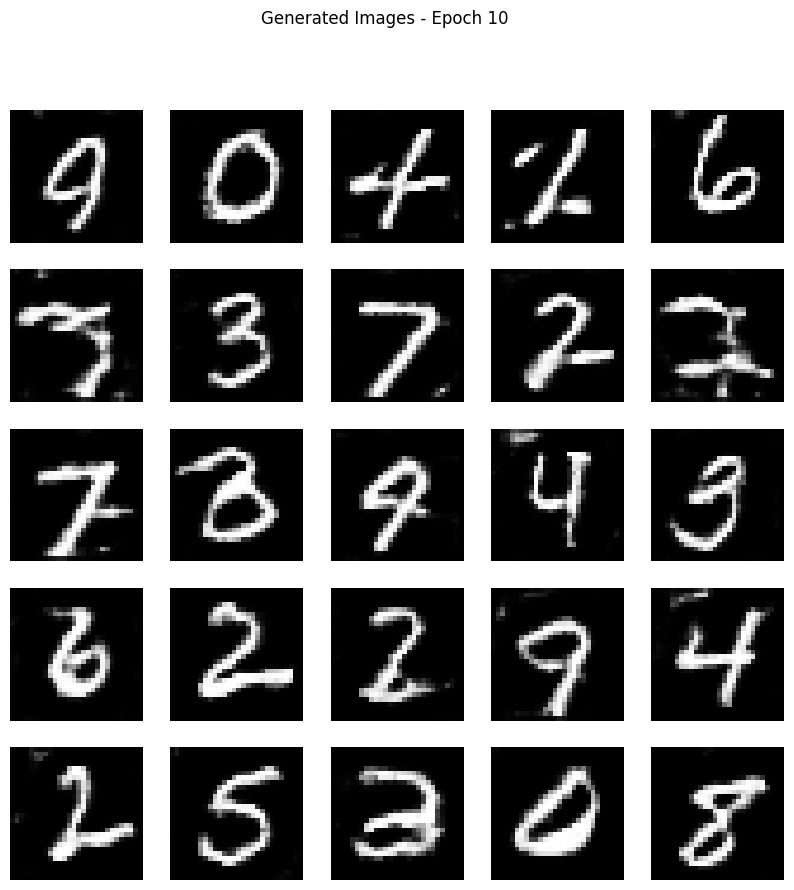

Discriminator Loss: 1.3423, Generator Loss: 0.6508
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20


KeyboardInterrupt: 

In [14]:
# Train the model
train(epochs=20, batch_size=64)

In [ ]:
# After training, generate a larger set of images
def generate_image_grid(generator, n_images=100):
    """
    Generate a grid of images using the trained generator.
    
    Args:
        generator: Trained generator model
        n_images: Number of images to generate (should be a square number)
    """
    # Generate random noise
    noise = tf.random.normal([n_images, LATENT_DIM])
    
    # Generate images
    generated_images = generator(noise, training=False)
    
    # Scale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    
    # Calculate grid dimensions
    grid_size = int(np.sqrt(n_images))
    
    # Create figure
    plt.figure(figsize=(15, 15))
    
    # Plot images
    for i in range(n_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.suptitle('Generated MNIST Digits', fontsize=16)
    plt.show()

# Generate images using random noise
def generate_specific_samples(generator, n_samples=10):
    """
    Generate and display a row of sample images.
    Useful for quick visualization of generator output.
    """
    noise = tf.random.normal([n_samples, LATENT_DIM])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle('Sample Generated Digits', fontsize=16)
    plt.show()

# After training, call these functions to visualize results
generate_image_grid(generator, n_images=100)  # Generate 10x10 grid
generate_specific_samples(generator, n_samples=10)  # Generate row of samples